In [14]:
import tensorflow as tf
from keras.preprocessing import image
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, RepeatVector, Dense, Activation, Lambda
from keras.models import Model

In [15]:
import matplotlib.pylab as plt
import os
from PIL import Image, ImageFilter, ImageDraw
import h5py
import tarfile
from google.colab import files
import numpy as np
import cv2
import time
from sklearn.model_selection import train_test_split
import csv  
from tqdm import tqdm
import shutil
from skimage import transform

In [3]:
!pip install tensorflowjs
import tensorflowjs as tfjs

     |████████████████████████████████| 71kB 2.1MB/s 
     |████████████████████████████████| 92kB 4.2MB/s 
     |████████████████████████████████| 137.3MB 86kB/s 
     |████████████████████████████████| 256kB 27.0MB/s 
     |████████████████████████████████| 921kB 28.9MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32852 sha256=63da2fa351060183d0cbe162bfce71ffa1fcd039953f98dbf41b4082a2c06a2e
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tensorflow-hub 0.9.0
    Uninstalling tensorflow-hub-0.9.0:
      Successfully uninstalled tensorflow-hub-0.9.0
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation:

In [16]:
'''
   Dataset is obtained from file 'IIIT5K-Word_V3.0.tar.gz'.
   The Dataset contains several files and 2 folders train and test.
   Files named traindata.m and testdata.m contains all the information related
       to the train and test images and their annotations respectively.
'''
os.chdir('/content')
tar = tarfile.open('IIIT5K-Word_V3.0.tar.gz')
tar.extractall()
tar.close()

In [17]:
os.chdir('/content/IIIT5K')

In [18]:
source = "test/"
dest = "train/"

files = os.listdir(source)
for f in files:
    shutil.move(source+f, dest)

Error: ignored

In [19]:
base_dir = os.getcwd()
train_dir = os.path.join(base_dir, 'train')
print(train_dir)

/content/IIIT5K/train


In [20]:
num_imgs_train = len(os.listdir(train_dir))
print('''
  Dataset Before Pre-processing
''')
print("number of images in training dataset is {}".format(num_imgs_train))


  Dataset Before Pre-processing

number of images in training dataset is 5000


In [21]:
def label_generation(filename):

  os.chdir('/content/IIIT5K')
  text_file = open(filename, "r")
  text = text_file.readlines()
  text_list = [ word[0:len(word)-1] for word in text]

  return text_list

In [22]:
test_labels = label_generation("Test_labels.txt")
test_label_img_locations = label_generation("Test_labels_img_loc.txt")


   Displaying random images from training data. Run this cell multiple times to check the data

Fig 1 corresponds to the label SIGN
Fig 2 corresponds to the label IN
Fig 3 corresponds to the label ONE
Fig 4 corresponds to the label PATTYS


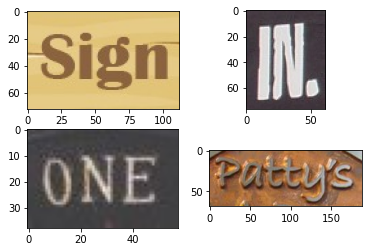

In [23]:
train_labels = label_generation("Train_labels.txt")
train_label_img_locations = label_generation("Train_labels_img_loc.txt")

dataset = []

i=0
for image in train_label_img_locations:
  dataset.append((image,train_labels[i]))
  i+=1

i=0
for image in test_label_img_locations:
  dataset.append((image,test_labels[i]))
  i+=1

print("""
   Displaying random images from training data. Run this cell multiple times to check the data
""")

for i in range(4):
  # Generating random number
  image_index = np.random.randint(len(dataset))
  plt.subplot(2,2,i+1)
  img = Image.open("train/"+dataset[image_index][0])
  plt.imshow(img)
  #plt.title(dataset[0][1])
  print("Fig "+str(i+1)+" corresponds to the label "+dataset[image_index][1])


In [24]:
def rotateImages(rotationAmt,img_loc):
  '''
    rotateImages is used as one of the image augumentation techniques to 
    increase the dataset thereby increasing the accuracy.

    rotateImages function rotates images in the current directory.

   Args:
   rotationAmt : int. The value of rotation in the image.
   img_loc: list. list containing image locations
   
  '''
  # for each image in the current directory
  i = 0
  for image in img_loc:
    # check if the image is already rotated. 
    if (image.find("rot") == -1): 
      img = Image.open(image)
      # get the image name
      img_name = list(image.split("."))[0]
      rotimg = img.rotate(rotationAmt)
      # saving the image with its rotation information as well.
      rotimg.save(img_name+"rot"+str(rotationAmt)+".jpg")
      img.close()  
      train_labels.append(train_labels[i])
      dataset.append((img_name+"rot"+str(rotationAmt)+".jpg",train_labels[i]))
      i+=1


In [25]:
def addBlur(img_loc):
  '''
    Adds Blur to the images.
    This function will list out all the images in the current directory and 
    applies blur to the image and saves it in the same folder.
    Args : 
    img_loc: list. list containing image locations
  '''
  # for each image in the current directory
  i = 0
  # for each image in the current directory
  for image in img_loc:
    img = Image.open(image)
    # adds blur to the image using ImageFilter.Blur
    blured_image = img.filter(ImageFilter.BLUR)
    # get the image name
    img_name = list(image.split("."))[0]
    # saving the image by adding the blur feature.
    blured_image.save(img_name+"blur.jpg")
    train_labels.append(train_labels[i])
    dataset.append((img_name+"blur.jpg",train_labels[i]))
    i+=1


In [26]:
def addUniformNoise(img_loc):
  '''
    Adds Uniform Noise to the images.
    This function will list out all the images in the current directory and 
    applies Uniform Noise to the image and saves it in the same folder.
    Args : 
    img_loc: list. list containing image locations
  '''
  # for each image in the current directory
  i = 0
  # for each image in the current directory
  for image_name in img_loc:
    image = cv2.imread(image_name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # creating random noise
    uniform_noise = np.zeros((image.shape[0], image.shape[1]),dtype=np.uint8)
    cv2.randu(uniform_noise,0,255)
    uniform_noise = (uniform_noise*0.2).astype(np.uint8)
    # Adding noise to the image
    noisy_image2 = cv2.add(gray,uniform_noise)
    noisy_image2 = cv2.cvtColor(noisy_image2,cv2.COLOR_GRAY2RGB)
    # get the image name
    img_name = list(image_name.split("."))[0]
    # saving the image by adding the uniform_noise feature.
    cv2.imwrite(img_name+"uniform_noise.jpg",noisy_image2)
    train_labels.append(train_labels[i])
    dataset.append((img_name+"uniform_noise.jpg",train_labels[i]))
    i+=1




In [28]:
def preprocessing():
  '''
  preprocessing techniques such as image rotation and image blur are applied to 
  the images in the current directory.
  '''
  # Rotating images of train_label_img_locations with an angle of 15 deg.
  rotateImages(15,train_label_img_locations)
  # Rotating images of test_label_img_locations with an angle of 15 deg.
  rotateImages(15,test_label_img_locations)

  # Rotating images of train_label_img_locations with an angle of -15 deg.
  rotateImages(-15,train_label_img_locations)
  # Rotating images of test_label_img_locations with an angle of -15 deg.
  rotateImages(-15,test_label_img_locations)

  # Blur images in train_label_img_locations
  addBlur(train_label_img_locations)
  # Blur images in test_label_img_locations
  addBlur(test_label_img_locations)

  # Adds Uniform Noise to images in train_label_img_locations
  addUniformNoise(train_label_img_locations)

  # Adds Uniform Noise to images in test_label_img_locations
  addUniformNoise(test_label_img_locations)

In [29]:
os.chdir('train')
# Preprocessing the images located in the train directory 
preprocessing()
os.chdir('/content/IIIT5K')

In [30]:
print(len(dataset))

25000


In [31]:
os.chdir('/content/IIIT5K')


  printing random images with their data augumented versions.

Column 1 images are taken from the dataset
Column 2 images represent + 15 degree rotation of images from the dataset
Column 3 images represent - 15 degree rotation of images from the dataset
Column 4 images represent blurred version of images from the dataset
Column 4 images represent noise version of images from the dataset



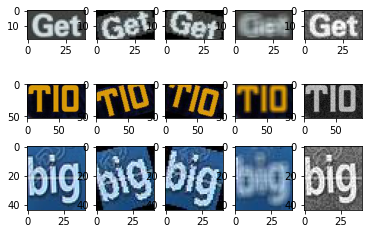

In [32]:
print('''
  printing random images with their data augumented versions.
''')

actual_training_data_length = 2000
j=1

for i in range(3):
  # Generating random number
  image_index = np.random.randint(actual_training_data_length)
  plt.subplot(3,5,j)
  img = Image.open("train/"+dataset[image_index][0])
  plt.imshow(img)
  plt.subplot(3,5,j+1)
  img = Image.open("train/"+dataset[image_index+5000][0])
  plt.imshow(img)
  plt.subplot(3,5,j+2)
  img = Image.open("train/"+dataset[image_index+10000][0])
  plt.imshow(img)
  plt.subplot(3,5,j+3)
  img = Image.open("train/"+dataset[image_index+15000][0])
  plt.imshow(img)
  plt.subplot(3,5,j+4)
  img = Image.open("train/"+dataset[image_index+20000][0])
  plt.imshow(img)
  #plt.title(dataset[0][1])
  #print("Fig "+str(i+1)+" corresponds to the label "+dataset[image_index][1])
  j+=5

print("Column 1 images are taken from the dataset")
print("Column 2 images represent + 15 degree rotation of images from the dataset")
print("Column 3 images represent - 15 degree rotation of images from the dataset")
print("Column 4 images represent blurred version of images from the dataset")
print("Column 4 images represent noise version of images from the dataset")
print()


  Dataset After Pre-processing

number of images in training dataset is 25000



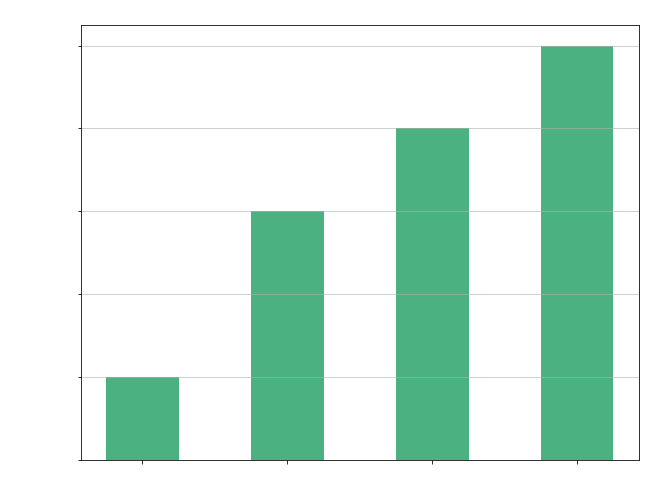

In [33]:

num_imgs_train = len(os.listdir(train_dir))

print('''
  Dataset After Pre-processing
''')
print("number of images in training dataset is {}".format(num_imgs_train))
print()
x = np.arange(4)
y = [5000, 15000, 20000, 25000]

plt.figure(figsize=[10,8])

plt.bar(x,y, width = 0.5, color='#00904C',alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Images',fontsize=15, color="#fff")
plt.xticks(x,('Without Data Augumentation',"± 15 deg rotation","Blur","noise"), color="#fff")
plt.yticks(fontsize=15, color="#fff")
plt.ylabel('Number Of Images',fontsize=15, color="#fff")
plt.title('Data Distribution after Data Augumentation',fontsize=15, color="#fff")
plt.show()

In [34]:
'''
  loading inception_resnet_v2 trained on imagenet dataset as per https://arxiv.org/pdf/1704.03549.pdf
  inception_resnet_v2 model is used as a feature extractor. 
  Later the features obtained are then passed to sequence to sequence model ( attention model ).
'''
pre_trained_model = tf.keras.applications.InceptionResNetV2(include_top=True, weights='imagenet', pooling=None)


225214464/225209952 [==============================] - 3s 0us/step


In [35]:
# freezing the weights of the model and removing the last layer
pre_trained_model.trainable = False
pre_trained_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [36]:
def load_and_process_img(image_path):
  '''
    Loads image in the Argument and and converts to size=(229,229,3) and
    returns numpy.ndarray used for getting features from the pre_trained_model.

    Args : 
    image_path : str. location path of the image

    Return : 
    img : numpy.ndarray . pre-processed image for passing into pre_trained_model
  '''

  # Load image with resizing it to a size of (229,229,3) 
  img = image.load_img(image_path, target_size=(299,299, 3))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [37]:

# Getting important layers for feature extraction from pre_trained_model.
# The layers are selected by referring to https://arxiv.org/pdf/1704.03549.pdf
imp_layers = ['mixed_7a','block8_1_conv']

# Taking out features from layer 'mixed_7a'
# with reference to the paper in https://arxiv.org/pdf/1704.03549.pdf
# an accuracy of 0.819 is achieved with the layer 'mixed_7a'

layer_name = 'block8_1_conv'

# Taking output from 'mixed_7a'
layer_output = pre_trained_model.get_layer(layer_name).output

# Generating a substance model from the pre_trained_model.
# model with input layer of pre_trained_model and output layer of 'mixed_7a'
feature_extraction_model = tf.keras.Model(inputs=pre_trained_model.input, outputs=layer_output)

In [ ]:
export_path_keras = "./feature_extraction_model.h5"
print(export_path_keras)

feature_extraction_model.save(export_path_keras)

In [ ]:
export_path = "./feature_extraction_model"
print(export_path)

tf.saved_model.save(feature_extraction_model,export_path)

In [ ]:
!zip -r modal.zip {export_path}

In [ ]:
files.download('./modal.zip')

In [ ]:
os.chdir('/content')

In [ ]:
!tensorflowjs_converter --input_format=keras ./feature_extraction_model/feature_extraction_model.h5 ./web_feature_extractor

In [ ]:
!zip -r js_model.zip web_feature_extractor

In [ ]:
files.download('js_model.zip')

In [38]:
from keras.preprocessing import image

os.chdir('train')

# Loading and processing image '1009_2.png'
input_data,path = load_and_process_img('1009_2.png')

# getting features from the feature_extraction_model
result = feature_extraction_model.predict(input_data)

print(f"The feature extracted has a shape (m, n_H, n_W, n_C) = {result.shape}")
(m,n_H,n_W,n_C) = result.shape

# Un-Rolling the 4D image to 3D image
reshaped_result = tf.reshape(result, shape=(m,n_H*n_W,n_C))

print(f"Unrolled result is of shape (m, n_H*n_W, n_C) = {reshaped_result.shape}")

os.chdir('/content/IIIT5K')

The feature extracted has a shape (m, n_H, n_W, n_C) = (1, 8, 8, 2080)
Unrolled result is of shape (m, n_H*n_W, n_C) = (1, 64, 2080)


In [39]:
os.chdir('/content/IIIT5K/train')

print(len(os.listdir(os.getcwd())))
os.chdir('/content/IIIT5K')

25000


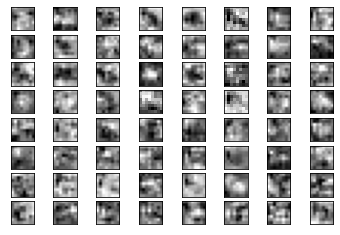

<Figure size 432x288 with 0 Axes>

In [40]:

'''	Plotting Various Features obtained from feature_extraction_model. '''

plot_limit = 8
index = 1
i=1500
for _ in range(plot_limit):
	for _ in range(plot_limit):
		# specify subplot and turn of axis
		ax = plt.subplot(plot_limit, plot_limit, index)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(result[0, :, :, i-1], cmap='gray')
		index += 1;i-=1
# show the figure
plt.show()
# Saving the Plot for future reference.
plt.savefig('Activations1.png')

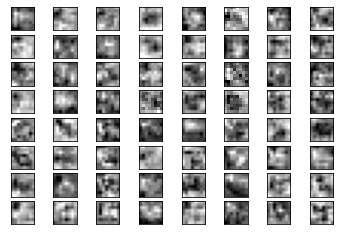

<Figure size 432x288 with 0 Axes>

In [41]:
# PLoting various features from the feature_extraction_model
plot_limit = 8
index = 1
layer_no = 1087
for _ in range(plot_limit):
	for _ in range(plot_limit):
		# specify subplot and turn of axis
		ax = plt.subplot(plot_limit, plot_limit, index)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(result[0, :, :, layer_no], cmap='gray')
		index += 1;layer_no -= 1;
# show the figure
plt.show()
plt.savefig('Activations2.png')

In [42]:
def string_to_int(string, length, vocab):
  '''
    Converts words to list of numbers

    Args : 
    string : str. The word which is to be converted to list of numbers.
    length : int. Max length limit of the list. strings over length are removed.
    vocab : dict. Dictonary which contains letter to number encoding.

    Returns : 
    rep : list. a list of numbers representing the word
  '''
  
  # converting the word to lowercase
  string = string.lower()

  # neglect the letters of the word, if the length of the word is
  # greater than the threshold(length)
  if len(string) > length:
      string = string[:length]
  rep = list(map(lambda x: vocab.get(x, '<unk>'), string))

  # Add padding for the letters of the word if the length of the word is
  # less than the threshold(length)
  if len(string) < length:
      rep += [vocab['<pad>']] * (length - len(string))
  
  # insert <start> in the first position
  rep.insert(0, vocab['<start>']) 
  return rep

In [43]:
# vocabulary has been taken from internet 
vocab = {
          ' ': 0, '.': 1, '/': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8,
         '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 
         'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22,'k':23 ,'l': 24, 'm': 25,
         'n': 26, 'o': 27, 'p': 28, 'q':29, 'r': 30, 's': 31, 't': 32, 'u': 33, 'v': 34,
         'w': 35, 'x': 36 ,'y': 37, 'z': 38, '<unk>': 39, '<pad>': 40, '<start>':41
}

In [44]:
def load_image(image_path):
    '''
      Converts the image to size = (299,299,3) and normalizes the data
      Args : 
      image_path : str. Image path for processing the image
    '''
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    # Normalizing the image
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [45]:
# Test code for checking the image shape and max value of image
os.chdir('train')
image, path = load_image('1009_2.png')
print(f"image has a shape of {image.shape}")
print(tf.reduce_max(image))
os.chdir('/content/IIIT5K')

image has a shape of (299, 299, 3)
tf.Tensor(0.6172209, shape=(), dtype=float32)


In [46]:
''' 
  img_name_vector , img_label_name contains image_paths, label_names
'''
img_name_vector = []
img_label_name = []

for (image_name,label) in dataset:
  img_name_vector.append(image_name)
  img_label_name.append(label)

In [47]:
os.chdir('train')

In [48]:
!mkdir features

In [ ]:
'''
  Passes each image of training set to feature_extraction_model to get its 
  features and then save it using numpy.
'''
encode_train = sorted(set(img_name_vector))
# Creating a proper dataset.
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
#passes each image through load_image function.
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  # Extracts features from the feature_extraction_model.
  batch_features = feature_extraction_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    # renaming the path where the features are to be stored.
    img_name = str(p.numpy())[1:]
    img_name = img_name[1:len(img_name)-1]
    img_name = "features/"+list(img_name.split("."))[0]
    img_name = tf.convert_to_tensor(img_name)
    path_of_feature = img_name.numpy().decode("utf-8")
    # saving each feature.
    np.save(path_of_feature, bf.numpy())

 28%|██▊       | 441/1563 [02:32<06:17,  2.97it/s]

In [ ]:
os.chdir('/content/IIIT5K')

In [ ]:
''' If You want to download the features then run this cell '''
#!zip -r /content/Train_data features
#files.download("Train_data.zip")

' If You want to download the features then run this cell '

In [ ]:
def get_labels_from_dataset(img_label_list,T_Y,vocab):
  '''
    Converts words to its corresponding numbers using vocab defined above
  '''
  Y = np.array([np.asarray(string_to_int(word,T_Y,vocab)).astype(np.int32) for word in img_label_list])

  return Y

In [ ]:
img_label_vector = get_labels_from_dataset(img_label_name,20,vocab)

In [ ]:
print(type(img_label_vector))

<class 'numpy.ndarray'>


In [ ]:
''' creating a dataset for training the features accross sequence model '''

# img_feature_name contains location of the corresponding feature name
img_feature_name = []
for img in img_name_vector:
  img_feature_name.append("features/"+img[:len(img)-4])

# checking for any errors in the dataset.
for i in range(len(img_name_vector)):
  if ("features/"+img_name_vector[i][:len(img_name_vector[i])-4] != img_feature_name[i]):
    print(f"error at {i}")
    break

In [ ]:
# differentiating the complete dataset into training and validating datasets.
img_name_train, img_name_val, output_label_train, output_label_val = train_test_split(
                                                                    img_feature_name,
                                                                    img_label_vector,
                                                                    test_size=0.0001,
                                                                    random_state=0)

print(f'Length of training images = {len(img_name_train)}')
print(f'Length of training labels = {len(output_label_train)}')
print(f"Length of validating labels = {len(img_name_val)}")
print(f'Length of training labels = {len(output_label_val)}')

Length of training images = 24997
Length of training labels = 24997
Length of validating labels = 3
Length of training labels = 3


In [ ]:
# Defining Hyperparameters
# Test with different values
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(vocab)
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from Inception-Resnet-V2 is (64, 2080)
# These two variables represent that vector shape
features_shape = 2080
attention_features_shape = 64

In [ ]:
def map_func(img_name, label):
  '''
    maps input to output
    Args :
      img_name : Path to the feature
      label: Label for the img_name
    Return :
      img_tensor : features extracted for the image
      label: Label for the img_name
  '''
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, label

In [ ]:
# Creating dataset corresponding to image features and image label
img_label_dataset = tf.data.Dataset.from_tensor_slices((img_name_train, output_label_train))

# Use map to load the numpy files in parallel
img_label_dataset = img_label_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch with hyperparameters
img_label_dataset = img_label_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
img_label_dataset = img_label_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class CNN_Encoder(tf.keras.Model):
    '''
      This encoder passes the features through a Fully connected layer.
      This is the 1st step of sequence model.
    '''
    def __init__(self, embedding_dim):
        ''' 
          function automatically called when an object is created ( constructor )
          Args : 
            embedding_dim : int. defines the embedded dimension of the encoder network.
        '''
      
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        '''
          passes the input through the encoder network.
          Args :
            x : input features
          Returns :
            x : activations of the encoder network
        '''
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class BahdanauAttention(tf.keras.Model):
  '''
      This Attention layer passes the features through a Neural network to
      calculate contexts.
      This is the 2st step of sequence model.
  '''
  def __init__(self, units):
    ''' 
     function automatically called when an object is created ( constructor )
     Args : 
       units : int. defines the number of units in the attention layer.
    '''
    super(BahdanauAttention, self).__init__()
    # Neural network to compute contexts.
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    '''
      passes the input through the encoder network.
      Args :
        x : input features
      Returns :
        context_vector : output of attention network. ( Input to decoder ).
        attention_weights : weights of the current node to be multiplied with
                            output of encoder. 
    '''
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class RNN_Decoder(tf.keras.Model):
  '''
      This Decoder layer passes the contexts through a GRU to
      calculate characters in the image.
      This is the final step of sequence model and also OCR.
  '''
  def __init__(self, embedding_dim, units, vocab_size):
    ''' 
      function automatically called when an object is created ( constructor )
      Args : 
        embedding_dim : int. defines the embedded dimension of the encoder network.
        units : int. defines the number of units in the attention layer.
        vocab_size : int. defines the vocab size
    '''
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    '''
      passes the input through the decoder network.
      Args :
        x : input features
        features : features of the image
        hidden : n_s i.e results of previous time_stamp 
      Returns :
        state : output of decoder network.
        attention_weights : weights of the current node to be multiplied with
                            output of encoder. 
    '''
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:

vocab_size = len(list(vocab.keys()))
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
# choosing Adam as the optimizer.
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
# Defining checkpoints to save weights of the encoder and decoder
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([1] * target.shape[0], 1)
  
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
os.chdir('train')

In [ ]:
EPOCHS = 32

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(img_label_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.5589
Epoch 1 Batch 100 Loss 0.7215
Epoch 1 Batch 200 Loss 0.7164
Epoch 1 Batch 300 Loss 0.7302
Epoch 1 Loss 0.774029
Time taken for 1 epoch 382.33729243278503 sec

Epoch 2 Batch 0 Loss 0.7278
Epoch 2 Batch 100 Loss 0.7078
Epoch 2 Batch 200 Loss 0.6480
Epoch 2 Batch 300 Loss 0.6655
Epoch 2 Loss 0.685194
Time taken for 1 epoch 372.5706355571747 sec

Epoch 3 Batch 0 Loss 0.6797
Epoch 3 Batch 100 Loss 0.6295
Epoch 3 Batch 200 Loss 0.6339
Epoch 3 Batch 300 Loss 0.6271
Epoch 3 Loss 0.667006
Time taken for 1 epoch 375.7288029193878 sec

Epoch 4 Batch 0 Loss 0.6876
Epoch 4 Batch 100 Loss 0.6834
Epoch 4 Batch 200 Loss 0.6260
Epoch 4 Batch 300 Loss 0.6080
Epoch 4 Loss 0.653816
Time taken for 1 epoch 379.57210969924927 sec

Epoch 5 Batch 0 Loss 0.6503
Epoch 5 Batch 100 Loss 0.6610
Epoch 5 Batch 200 Loss 0.6082
Epoch 5 Batch 300 Loss 0.5700
Epoch 5 Loss 0.642265
Time taken for 1 epoch 378.89802718162537 sec

Epoch 6 Batch 0 Loss 0.6133
Epoch 6 Batch 100 Loss 0.6332
Epoch 6 B

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
os.chdir('/content')

In [ ]:
os.chdir('/content/IIIT5K/train/checkpoints')

In [ ]:
!zip -r /content/checkpoints train

  adding: train/ (stored 0%)
  adding: train/checkpoint (deflated 68%)
  adding: train/ckpt-3.index (deflated 68%)
  adding: train/ckpt-4.data-00000-of-00001 (deflated 24%)
  adding: train/ckpt-1.data-00000-of-00001 (deflated 24%)
  adding: train/ckpt-4.index (deflated 68%)
  adding: train/ckpt-1.index (deflated 68%)
  adding: train/ckpt-2.data-00000-of-00001 (deflated 24%)
  adding: train/ckpt-3.data-00000-of-00001 (deflated 24%)
  adding: train/ckpt-2.index (deflated 68%)


In [ ]:
os.chdir('/content')

In [ ]:
!mkdir Encoder_weights Decoder_weights

In [ ]:
encoder.save_weights('Encoder_weights/my_checkpoint')

In [ ]:
decoder.save_weights('Decoder_weights/my_checkpoint')

In [ ]:
!zip -r /content/Encoder_weights Encoder_weights

  adding: Encoder_weights/ (stored 0%)
  adding: Encoder_weights/checkpoint (deflated 49%)
  adding: Encoder_weights/my_checkpoint.index (deflated 31%)
  adding: Encoder_weights/my_checkpoint.data-00000-of-00001 (deflated 7%)


In [ ]:
!zip -r /content/Decoder_weights Decoder_weights

  adding: Decoder_weights/ (stored 0%)
  adding: Decoder_weights/checkpoint (deflated 49%)
  adding: Decoder_weights/my_checkpoint.index (deflated 58%)
  adding: Decoder_weights/my_checkpoint.data-00000-of-00001 (deflated 8%)


In [ ]:
""" Download the Encoder_weights.zip and Decoder_weights.zip for future use. """ 

' Download the Encoder_weights.zip and Decoder_weights.zip for future use. '

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((20, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = feature_extraction_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([vocab["/"]], axis=0)
    
    result = []

    for i in range(20):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()

        result.append(predicted_id)

        if predicted_id == 39:
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    temp_att = np.resize(attention_plot[l], (8, 8))
    ax = fig.add_subplot(len_result//2, len_result//2, l+1)
    ax.set_title(result[l])
    img = ax.imshow(temp_image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
os.chdir("IIIT5K/train")

In [ ]:
# OCR on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
image = image[9:]+".jpg"
real_caption = output_label_val[rid]
result, attention_plot = evaluate(image)

print ('Real Caption :', real_caption)
print('Prediction Caption : ', result)
#print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


In [ ]:
    attention_plot = np.zeros((20, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = feature_extraction_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([vocab[" "]], axis=0)
    
    result = []

    for i in range(20):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()

        result.append(predicted_id)

        if predicted_id == 39:
            break

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]

(1, 64, 256) (1, 512) (1, 1)
